# Seol Bike Rental Prediction 


# Preliminary Wrangling

This document explores a dataset containing first 20 days of each month. 

In [3]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

import sklearn
#import keras
#from keras.models import Sequential
#from keras.layers import Dense
import matplotlib.pyplot as plt

import xgboost as xgb

%matplotlib inline

In [4]:
# load in the dataset into a pandas dataframe, print statistics

bikes = pd.read_csv('train.csv', parse_dates=[1], dayfirst=True)

In [5]:
bikes['year'] = pd.to_datetime(bikes.Date).dt.year
bikes['month'] = pd.to_datetime(bikes.Date).dt.month
bikes['day'] = pd.to_datetime(bikes.Date).dt.day
bikes['time'] = pd.to_datetime(bikes[['year', 'month', 'day', 'Hour']])
bikes = bikes.set_index('time')
bikes.drop(['year', 'month', 'day'], axis=1, inplace=True)

In [6]:
# high-level overview of data shape and composition
print(bikes.shape)
print(bikes.dtypes)

(5760, 15)
ID                                    int64
Date                         datetime64[ns]
y                                     int64
Hour                                  int64
Temperature(�C)                     float64
Humidity(%)                           int64
Wind speed (m/s)                    float64
Visibility (10m)                      int64
Dew point temperature(�C)           float64
Solar Radiation (MJ/m2)             float64
Rainfall(mm)                        float64
Snowfall (cm)                       float64
Seasons                              object
Holiday                              object
Functioning Day                      object
dtype: object


In [7]:
print(bikes.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5760 entries, 2017-12-01 00:00:00 to 2018-11-20 23:00:00
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         5760 non-null   int64         
 1   Date                       5760 non-null   datetime64[ns]
 2   y                          5760 non-null   int64         
 3   Hour                       5760 non-null   int64         
 4   Temperature(�C)            5760 non-null   float64       
 5   Humidity(%)                5760 non-null   int64         
 6   Wind speed (m/s)           5760 non-null   float64       
 7   Visibility (10m)           5760 non-null   int64         
 8   Dew point temperature(�C)  5760 non-null   float64       
 9   Solar Radiation (MJ/m2)    5760 non-null   float64       
 10  Rainfall(mm)               5760 non-null   float64       
 11  Snowfall (cm)              5760 n

In [8]:
bikes.head(5)

ID       Date    y  Hour  Temperature(�C)  Humidity(%)  \
time                                                                          
2017-12-01 00:00:00   0 2017-12-01  254     0             -5.2           37   
2017-12-01 01:00:00   1 2017-12-01  204     1             -5.5           38   
2017-12-01 02:00:00   2 2017-12-01  173     2             -6.0           39   
2017-12-01 03:00:00   3 2017-12-01  107     3             -6.2           40   
2017-12-01 04:00:00   4 2017-12-01   78     4             -6.0           36   

                     Wind speed (m/s)  Visibility (10m)  \
time                                                      
2017-12-01 00:00:00               2.2              2000   
2017-12-01 01:00:00               0.8              2000   
2017-12-01 02:00:00               1.0              2000   
2017-12-01 03:00:00               0.9              2000   
2017-12-01 04:00:00               2.3              2000   

                     Dew point temperature(�C)  Solar Radiation (MJ/m2)  \
time                                                                      
2017-12-01 00:00:00                      -17.6                      0.0   
2017-12-01 01:00:00                      -17.6                      0.0   
2017-12-01 02:00:00                      -17.7                      0.0   
2017-12-01 03:00:00                      -17.6                      0.0   
2017-12-01 04:00:00                      -18.6                      0.0   

                     Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
time                                                                   
2017-12-01 00:00:00           0.0            0.0  Winter  No Holiday   
2017-12-01 01:00:00           0.0            0.0  Winter  No Holiday   
2017-12-01 02:00:00           0.0            0.0  Winter  No Holiday   
2017-12-01 03:00:00           0.0            0.0  Winter  No Holiday   
2017-12-01 04:00:00           0.0            0.0  Winter  No Holiday   

                    Functioning Day  
time                                 
2017-12-01 00:00:00             Yes  
2017-12-01 01:00:00             Yes  
2017-12-01 02:00:00             Yes  
2017-12-01 03:00:00             Yes  
2017-12-01 04:00:00             Yes

In [9]:
# descriptive statistics for numeric variables
bikes.describe().T

count         mean          std   min      25%  \
ID                         5760.0  2879.500000  1662.913107   0.0  1439.75   
y                          5760.0   703.483854   655.249491   0.0   188.00   
Hour                       5760.0    11.500000     6.922788   0.0     5.75   
Temperature(�C)            5760.0    12.803559    11.902206 -15.1     3.20   
Humidity(%)                5760.0    58.361806    19.840167   0.0    43.00   
Wind speed (m/s)           5760.0     1.723333     1.047898   0.0     0.90   
Visibility (10m)           5760.0  1473.711458   585.879880  27.0  1025.75   
Dew point temperature(�C)  5760.0     4.058264    13.003582 -26.9    -5.40   
Solar Radiation (MJ/m2)    5760.0     0.572325     0.869943   0.0     0.00   
Rainfall(mm)               5760.0     0.135122     1.075320   0.0     0.00   
Snowfall (cm)              5760.0     0.046302     0.323728   0.0     0.00   

                               50%       75%      max  
ID                         2879.50  4319.250  5759.00  
y                           485.50  1066.000  3556.00  
Hour                         11.50    17.250    23.00  
Temperature(�C)              13.70    22.225    39.40  
Humidity(%)                  57.00    73.000    98.00  
Wind speed (m/s)              1.50     2.300     7.40  
Visibility (10m)           1732.00  2000.000  2000.00  
Dew point temperature(�C)     5.20    14.700    27.20  
Solar Radiation (MJ/m2)       0.01     0.940     3.52  
Rainfall(mm)                  0.00     0.000    35.00  
Snowfall (cm)                 0.00     0.000     5.10

In [10]:
bikes.columns

Index(['ID', 'Date', 'y', 'Hour', 'Temperature(�C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(�C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')

In [11]:
#renaming coulumns:
features = ['ID','date' ,'y', 'hour', 'temperature', 'humidity',
            'wind_speed', 'visibility', 'dew_point_temp',
            'solar_radiation', 'rainfall', 'snowfall', 'seasons', 'holiday', 'functioning_day']
bikes.columns = features
bikes.head(1)

ID       date    y  hour  temperature  humidity  wind_speed  \
time                                                                      
2017-12-01   0 2017-12-01  254     0         -5.2        37         2.2   

            visibility  dew_point_temp  solar_radiation  rainfall  snowfall  \
time                                                                          
2017-12-01        2000           -17.6              0.0       0.0       0.0   

           seasons     holiday functioning_day  
time                                            
2017-12-01  Winter  No Holiday             Yes

In [12]:
# order seasons column:
ordered = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ["Winter", "Spring", "Summer", "Autumn" ])
bikes['seasons'] = bikes['seasons'].astype(ordered)

In [13]:
#Extract day of year:
bikes['year_day'] = pd.to_datetime(bikes.date).dt.dayofyear
bikes['weekday'] = pd.to_datetime(bikes.date).dt.weekday
bikes['month'] = pd.to_datetime(bikes.date).dt.month

In [14]:
bikes.head(1)

ID       date    y  hour  temperature  humidity  wind_speed  \
time                                                                      
2017-12-01   0 2017-12-01  254     0         -5.2        37         2.2   

            visibility  dew_point_temp  solar_radiation  rainfall  snowfall  \
time                                                                          
2017-12-01        2000           -17.6              0.0       0.0       0.0   

           seasons     holiday functioning_day  year_day  weekday  month  
time                                                                      
2017-12-01  Winter  No Holiday             Yes       335        4     12

### What is the structure of the dataset?

There are 5760 row in the dataset represents the number of bikes rented at each hour in the first 20 days of each month with 15 features (ID, Date, y(number of bikes), Hour, Temperature(C), Humidity(%), Wind speed (m/s), Visibility (10m), Dew point temperature(C), Solar Radiation (MJ/m2), Rainfall(mm), Snowfall (cm), Seasons, Holiday and Functioning Day). Most variables are numeric in nature, but the variables Seasons, Holiday, and Functioning Day are factor variables.


### What is/are the main feature(s) of interest in the dataset?

I'm most interested in figuring out what features are best for predicting the number of rented bikes of each hour in the remaining 10 days in the test dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that Hour variable will have the strongest effect on number of bikes rented. I also think that the Seasons, Holiday, and Functioning Day will have effects also.Temperature, Snowfall to have a much smaller degree than the main effect of Hour variable.



# Univariate Exploration

I'll start by looking at the distribution of the main variable of interest: y(number of bikes).

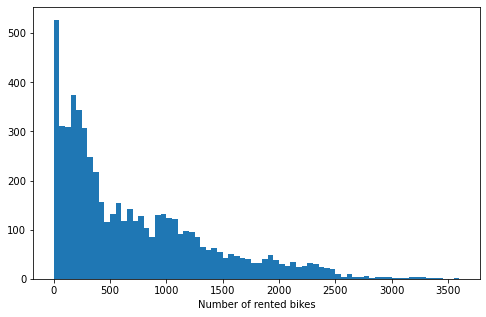

In [15]:
# start with a standard-scaled plot
binsize = 50
bins = np.arange(0, bikes['y'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'y', bins = bins)
plt.xlabel('Number of rented bikes')
plt.show()

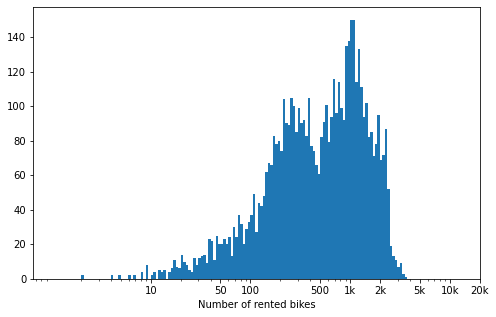

In [16]:
# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.025
bins = 10 ** np.arange(0, np.log10(bikes['y'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'y', bins = bins)
plt.xscale('log')
plt.xticks([10,50, 100 ,500, 1e3, 2e3, 5e3, 1e4, 2e4], [10,50, 100, 500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Number of rented bikes')
plt.show()

y(Number of bikes) has a long-tailed distribution, with a lot of hours with low bike rental, and few on the high bike rental. When plotted on a log-scale, the variable distribution looks roughly bimodal, with one peak between 200 and 300, and a second peak at 1000. Interesting!.

Now, let's see more insights about Seasons, Holiday, and Functioning Day

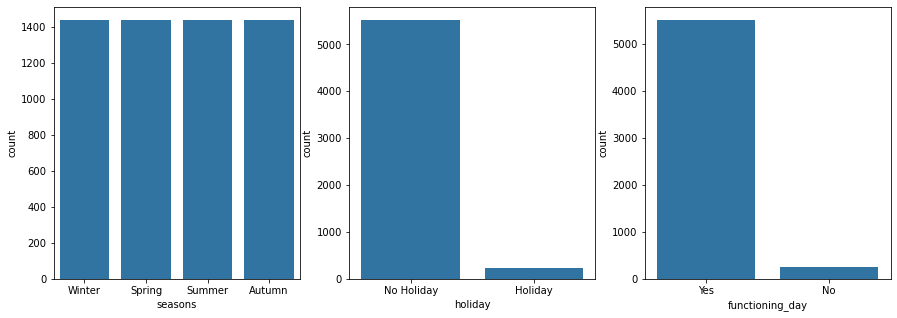

In [17]:
fig, ax = plt.subplots(ncols=3, figsize = [15,5])

default_color = sns.color_palette()[0]
sns.countplot(data = bikes, x = 'seasons', color = default_color, ax = ax[0])
sns.countplot(data = bikes, x = 'holiday', color = default_color, ax = ax[1])
sns.countplot(data = bikes, x = 'functioning_day', color = default_color, ax = ax[2])

plt.show()

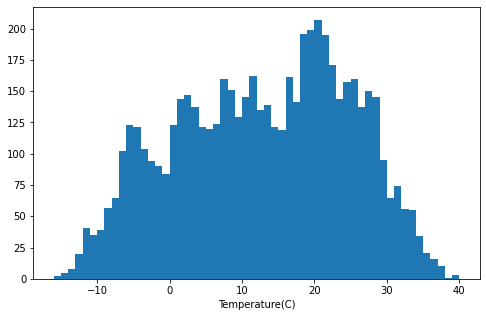

In [18]:
# Temperature(C)
binsize = 1
bins = np.arange(-16, bikes['temperature'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'temperature', bins = bins)
plt.xlabel('Temperature(C)')
plt.show()

as we could see from histogram above, tempreture follows multimodal distribution. the highest peak at 22C and lowest peak at about -5 C and in between we see multiple jumps.

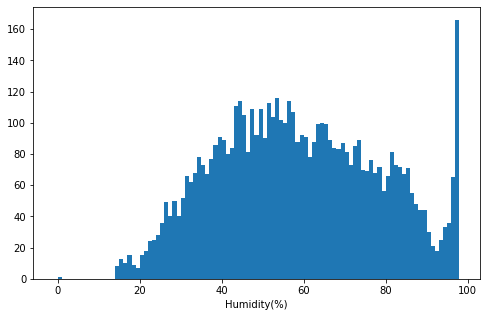

In [19]:
# Humidity(%)
binsize = 1
bins = np.arange(bikes['humidity'].min()-binsize, bikes['humidity'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'humidity', bins = bins)
plt.xlabel('Humidity(%)')
plt.show()

Humidity follows nearly the normal distribution model with outliers at (Humidity = 0%). in the right hand side of our histogram we could see a small left skewed distribution and (Humidity = 98%) has the most appearence in our data.    

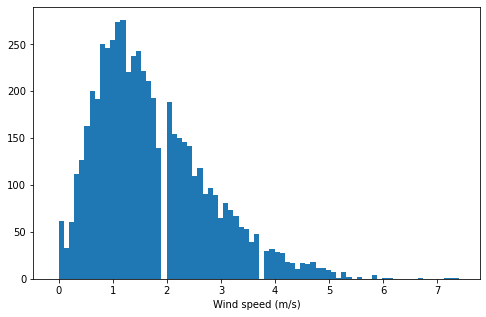

In [20]:
# Wind speed (m/s)
binsize = 0.095
bins = np.arange(bikes['wind_speed'].min()-binsize, bikes['wind_speed'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'wind_speed', bins = bins)
plt.xlabel('Wind speed (m/s)')
plt.show()

as we could see from distribution above, Wind speed has a right skewed distribution with peak at 1.20 m/s. There are some outliers beyond 5.0 m/s to be investigated.

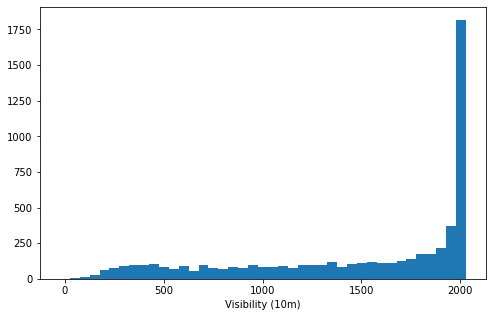

In [21]:
# Visibility (10m)
binsize = 50
bins = np.arange(bikes['visibility'].min()-binsize, bikes['visibility'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'visibility', bins = bins)
plt.xlabel('Visibility (10m)')
plt.show()

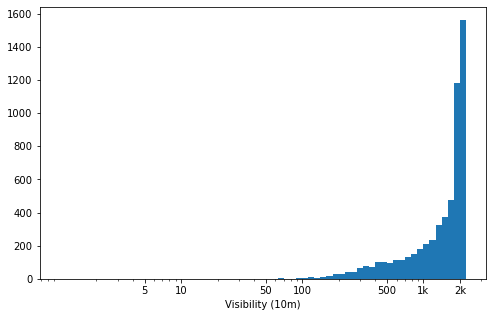

In [22]:
# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(bikes['visibility'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'visibility', bins = bins)
plt.xscale('log')
plt.xticks([5,10,50, 100 ,500, 1e3, 2e3], [5,10,50, 100, 500, '1k', '2k'])
plt.xlabel('Visibility (10m)')
plt.show()

We could see that Visibility has a extreme left skewed even if using log scale. About one third of our data has a visibility = 2000. 

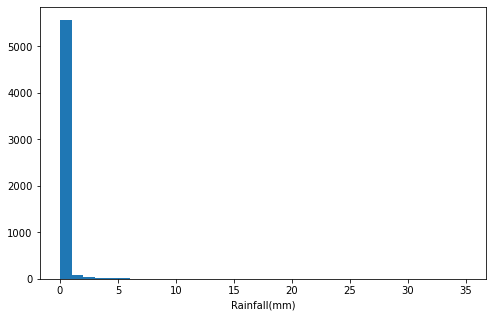

In [23]:
# Rainfall(mm)
binsize = 1
bins = np.arange(0, bikes['rainfall'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'rainfall', bins = bins)
plt.xlabel('Rainfall(mm)')
plt.show()

We have only 332 hours in our dataset with rain. 


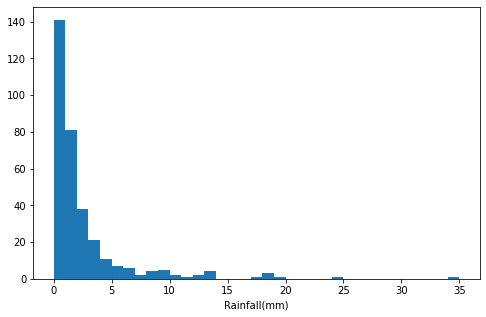

In [24]:
#display only hours with rainfall:
rainy = bikes[bikes['rainfall'] != 0]
print("We have only {} hours in our dataset with rain. ".format(rainy.shape[0]))
binsize = 1
bins = np.arange(0, rainy['rainfall'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = rainy, x = 'rainfall', bins = bins)
plt.xlabel('Rainfall(mm)')
plt.show()


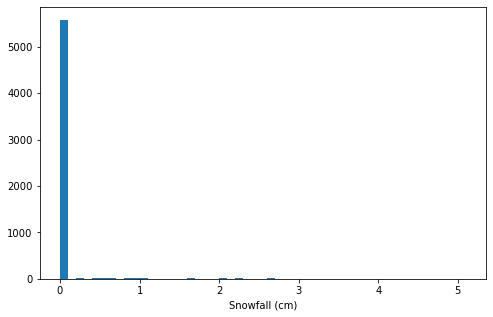

In [25]:
# Snowfall (cm)
binsize = 0.1
bins = np.arange(0, bikes['snowfall'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikes, x = 'snowfall', bins = bins)
plt.xlabel('Snowfall (cm)')
plt.show()

We have only 180 hours in our dataset with snowfall. 


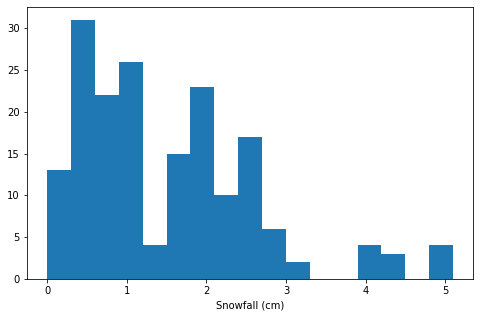

In [26]:
#display only hours with rainfall:
snow = bikes[bikes['snowfall'] != 0]
print("We have only {} hours in our dataset with snowfall. ".format(snow.shape[0]))
binsize = 0.30

bins = np.arange(0, snow['snowfall'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = snow, x = 'snowfall', bins = bins)
plt.xlabel('Snowfall (cm)')
plt.show()


we could clearly see that snowfall and rainfall has extremely right skewed distribution. we should check outliers above 15mm rainfall and above 3cm snowfall.

## Bivariate Exploration

To start off with, I want to look at the pairwise correlations present between features in the data.

In [27]:
numeric_vars = features[2:-3]

categoric_vars = ['seasons','holiday', 'functioning_day']
numeric_vars

['y',
 'hour',
 'temperature',
 'humidity',
 'wind_speed',
 'visibility',
 'dew_point_temp',
 'solar_radiation',
 'rainfall',
 'snowfall']

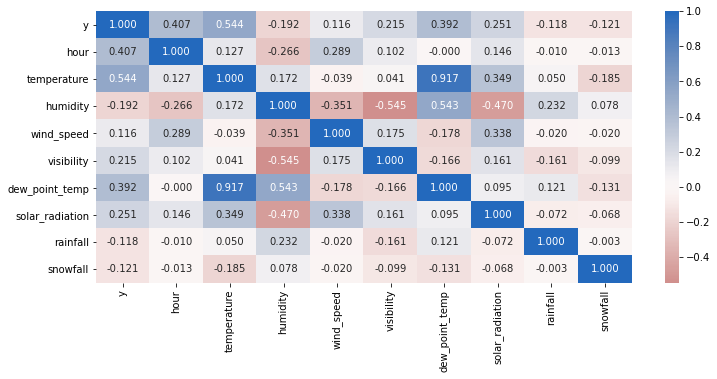

In [28]:
# correlation plot
plt.figure(figsize = [12, 5])
sns.heatmap(bikes[numeric_vars].corr(), annot = True, fmt = '.3f',cmap = 'vlag_r', center = 0)
plt.show()

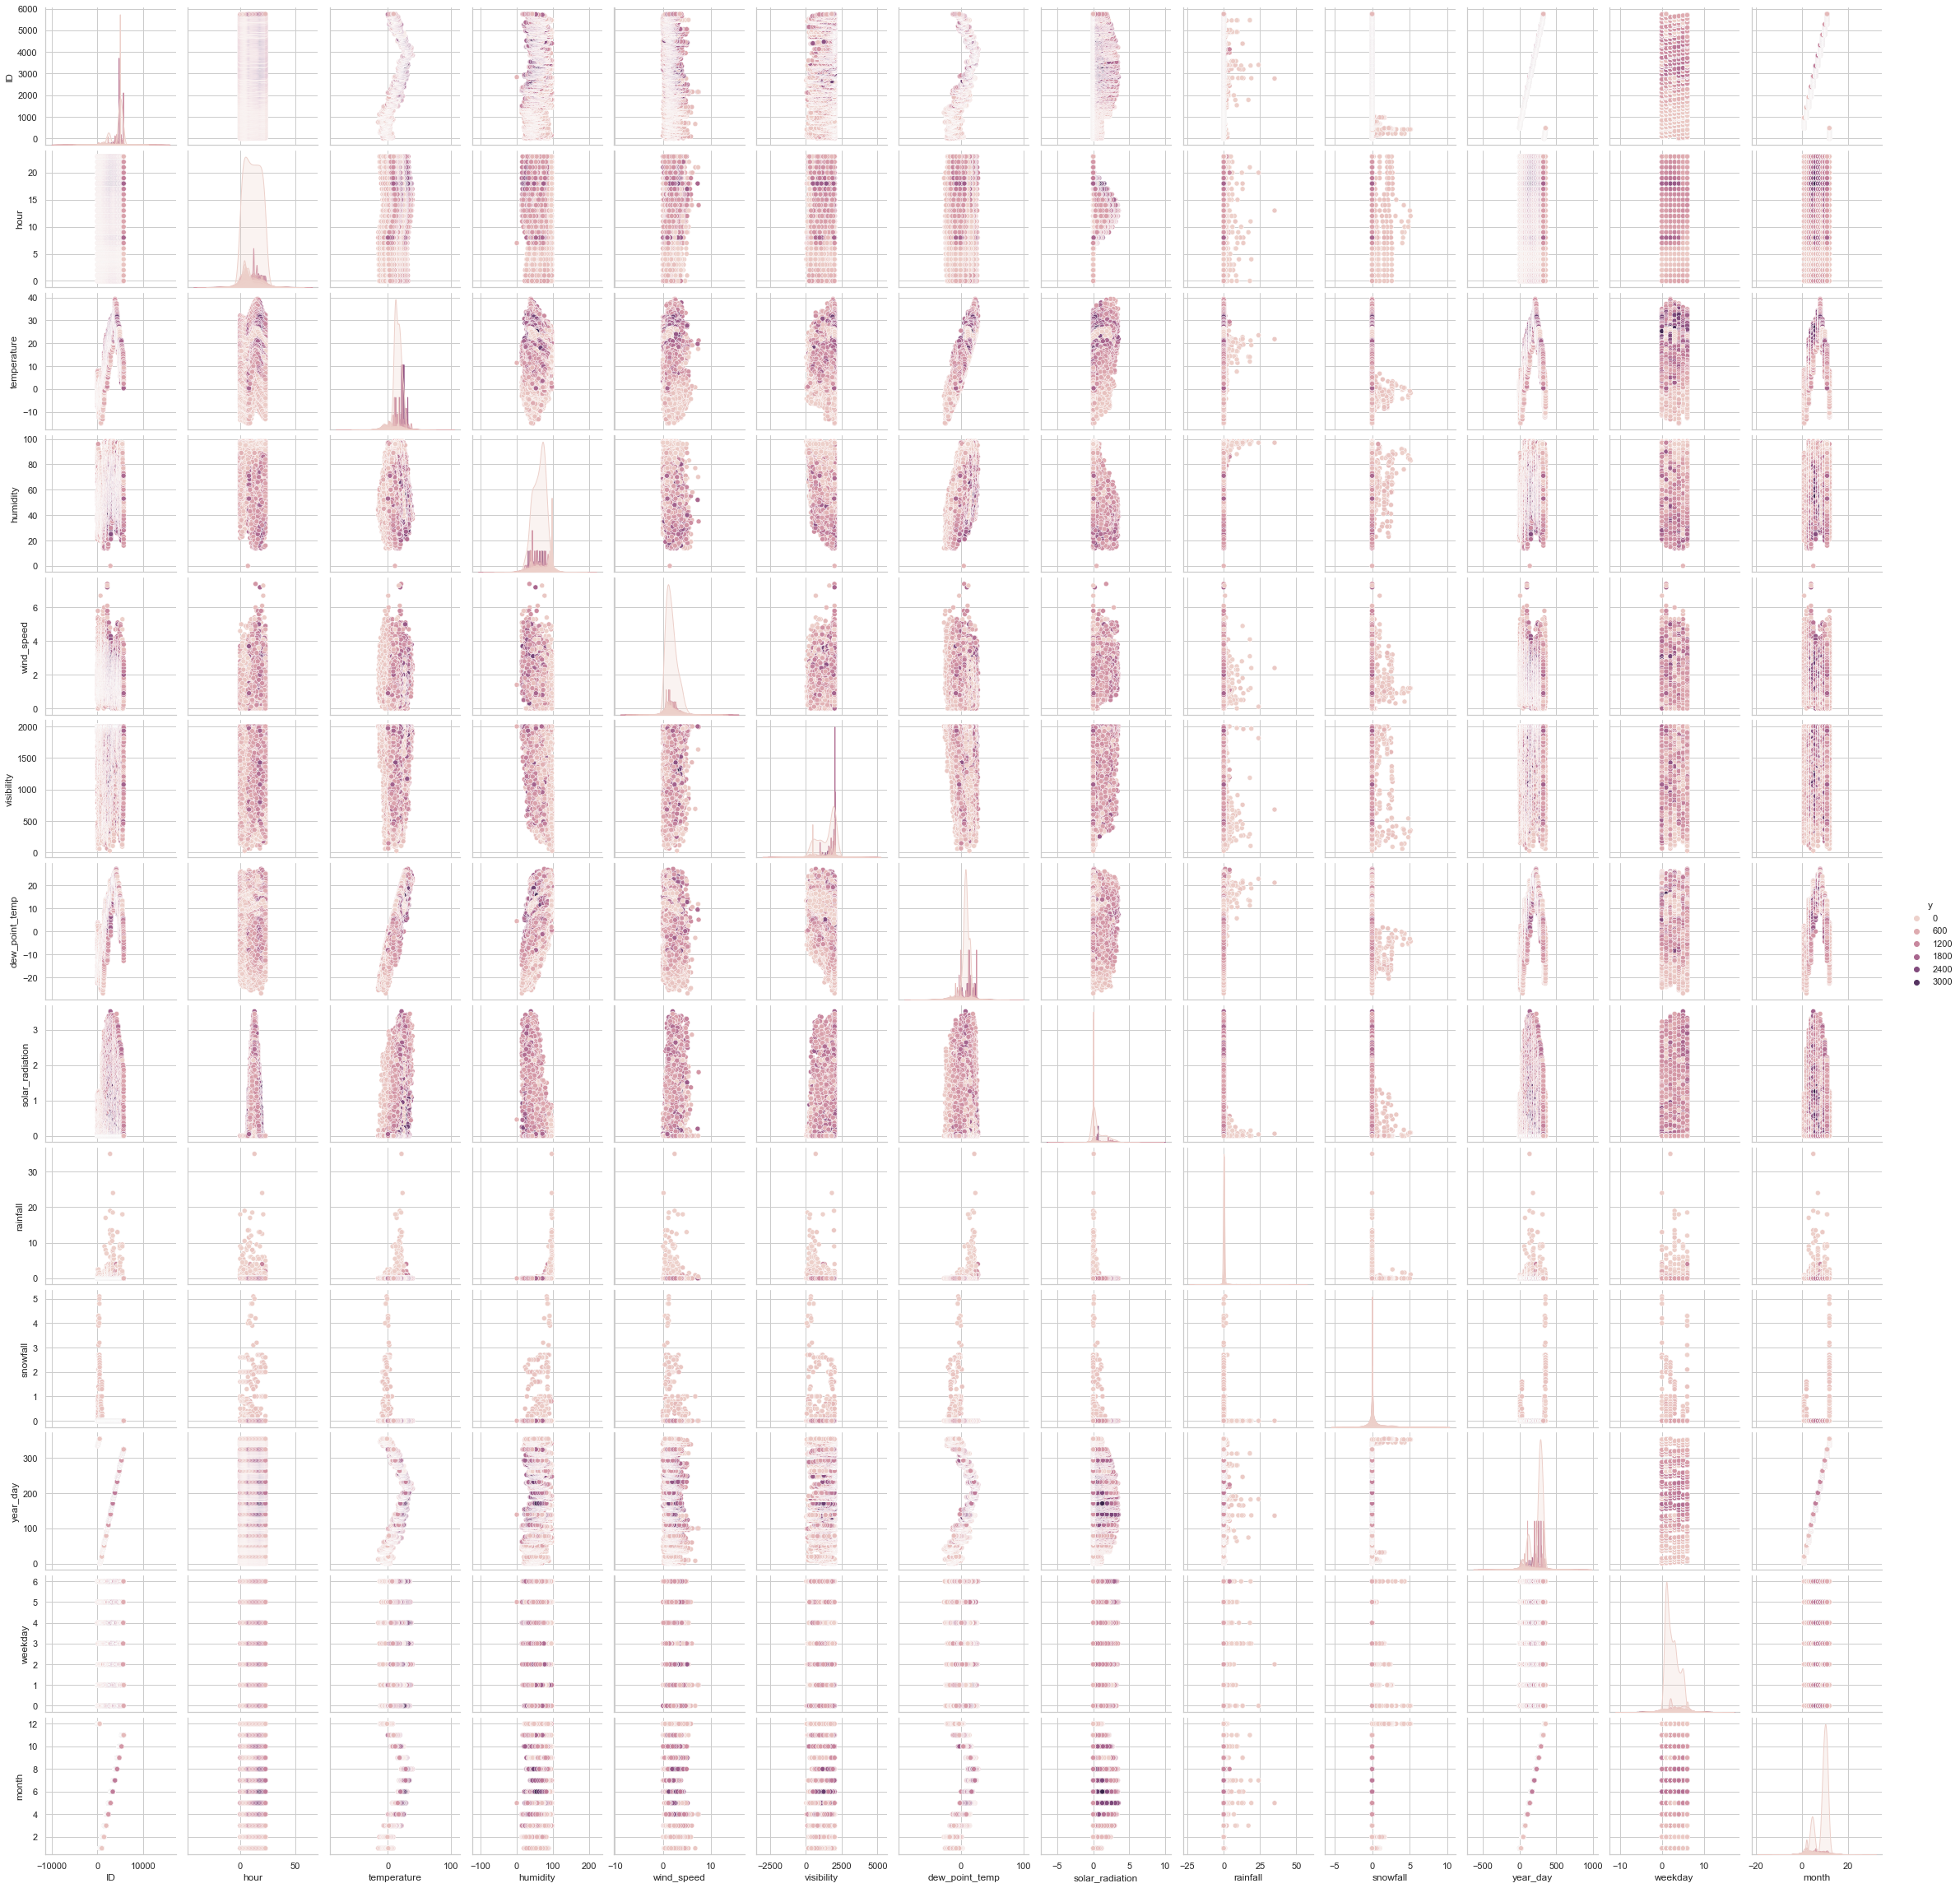

In [30]:
bikes.head()
sns.set_theme(style="whitegrid")
sns.pairplot(bikes, hue="y")

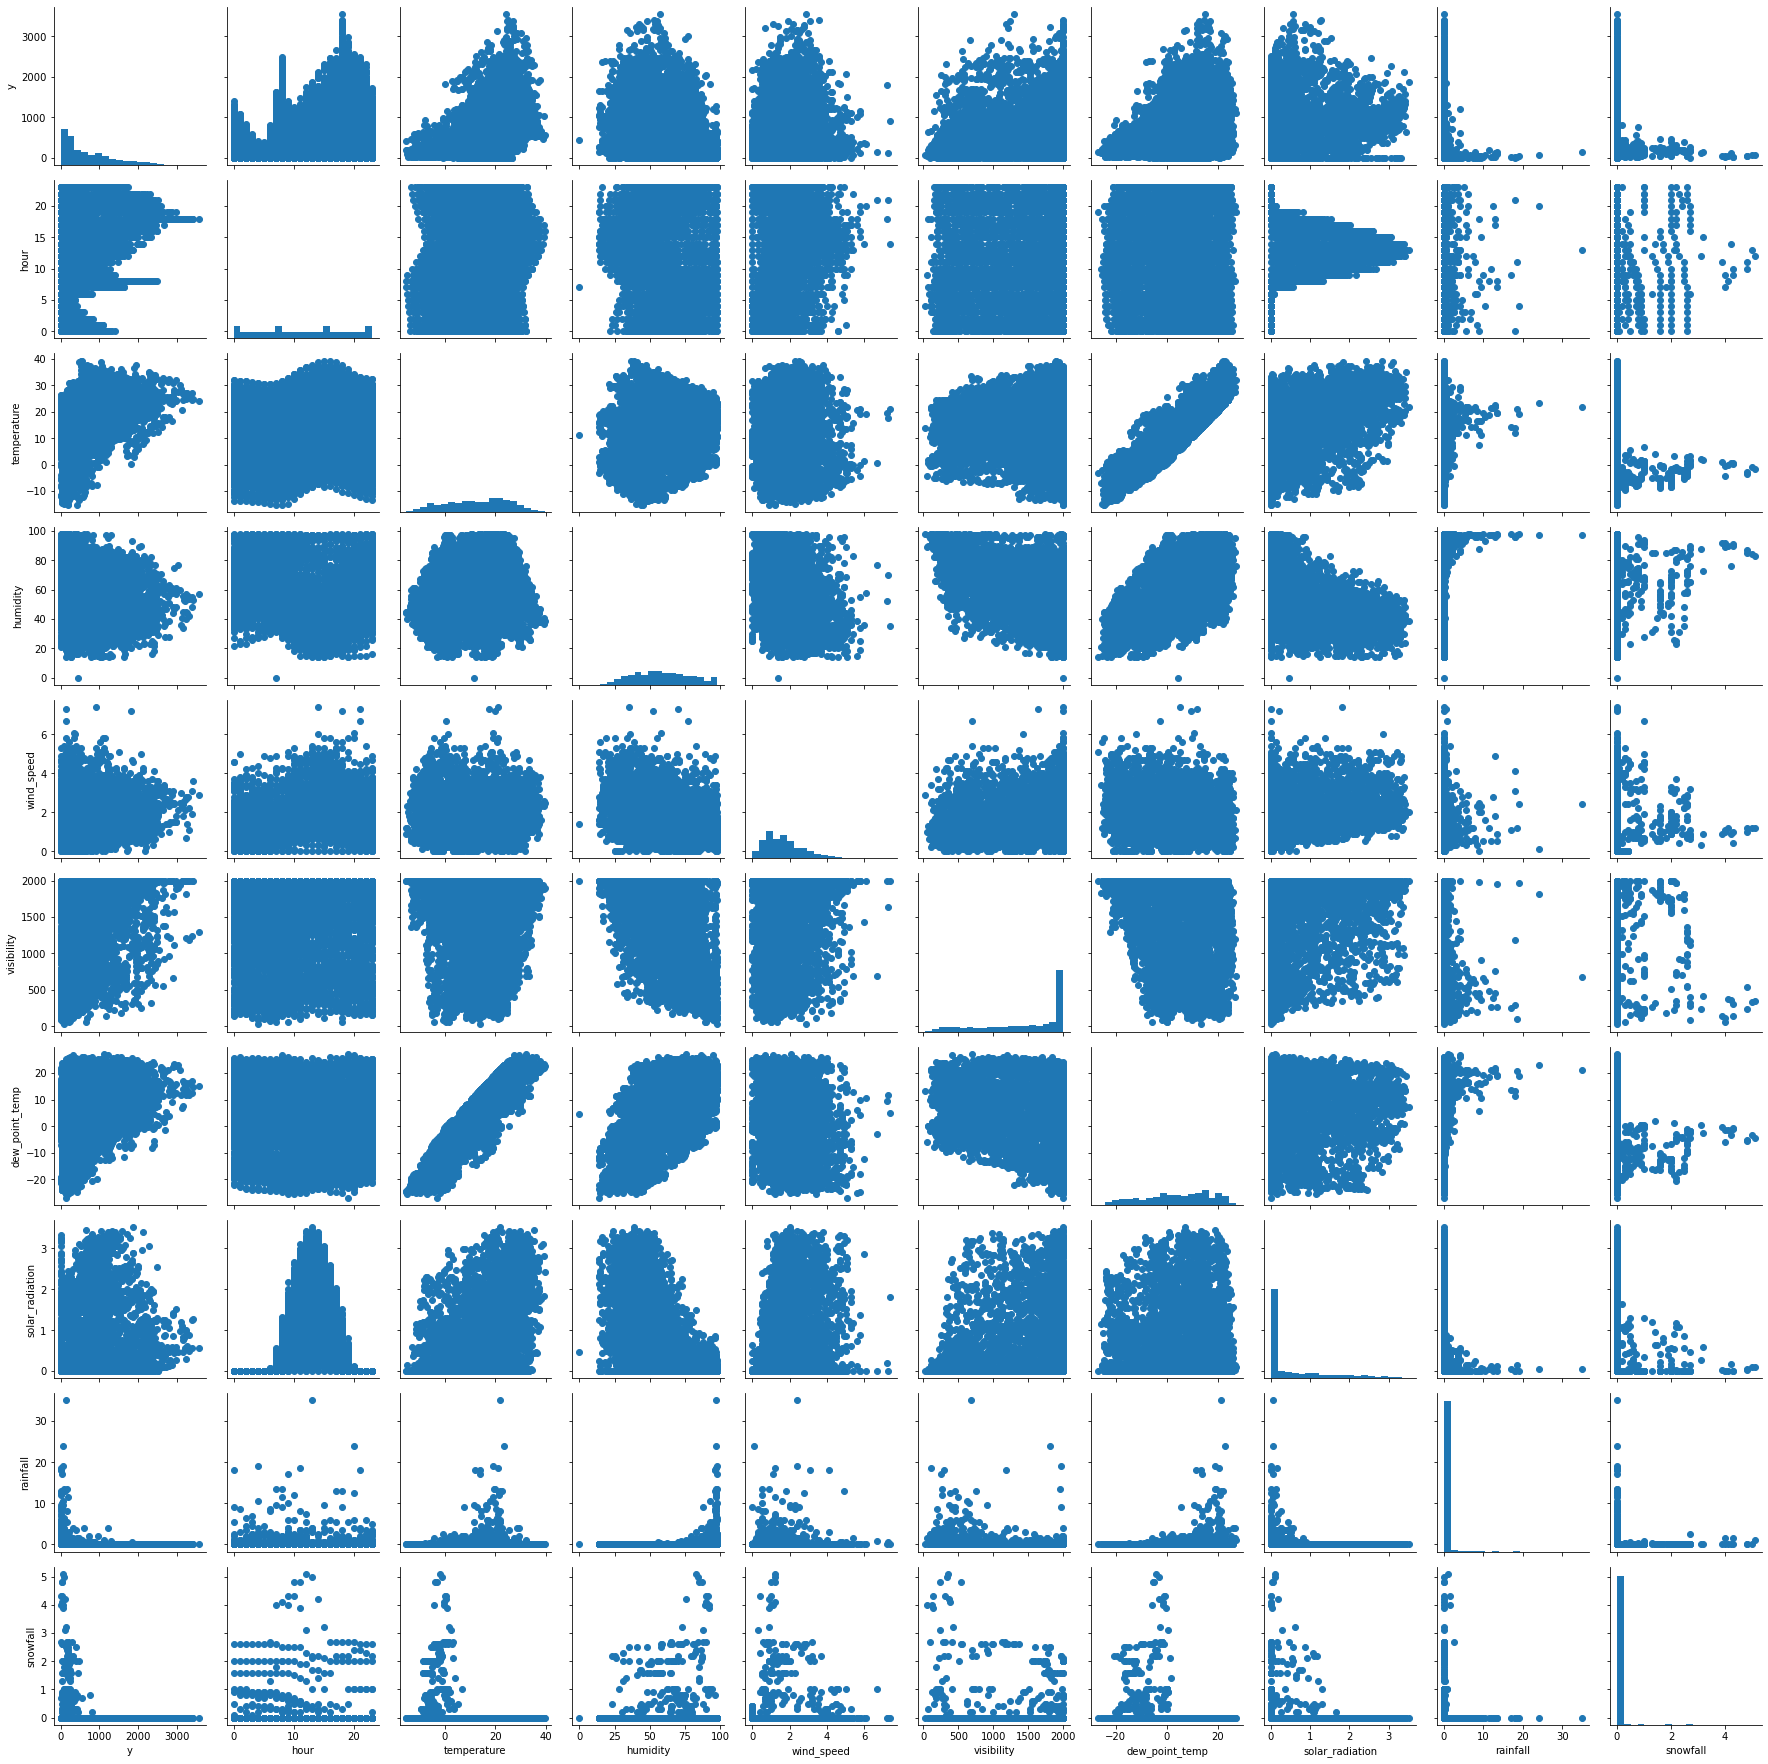

In [29]:
# pairplot

g = sns.PairGrid(data = bikes, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)

As we could see from charts above, there is a huge correlation as expexted between Temperature and Dew point temperature.
Also there is a negative correlation between humidity and visibility. 

If we look to the number of bikes rented we could see there is a correlation to hour and tempreture. this part needs more investigation with our categorical variables.

<Figure size 720x720 with 0 Axes>

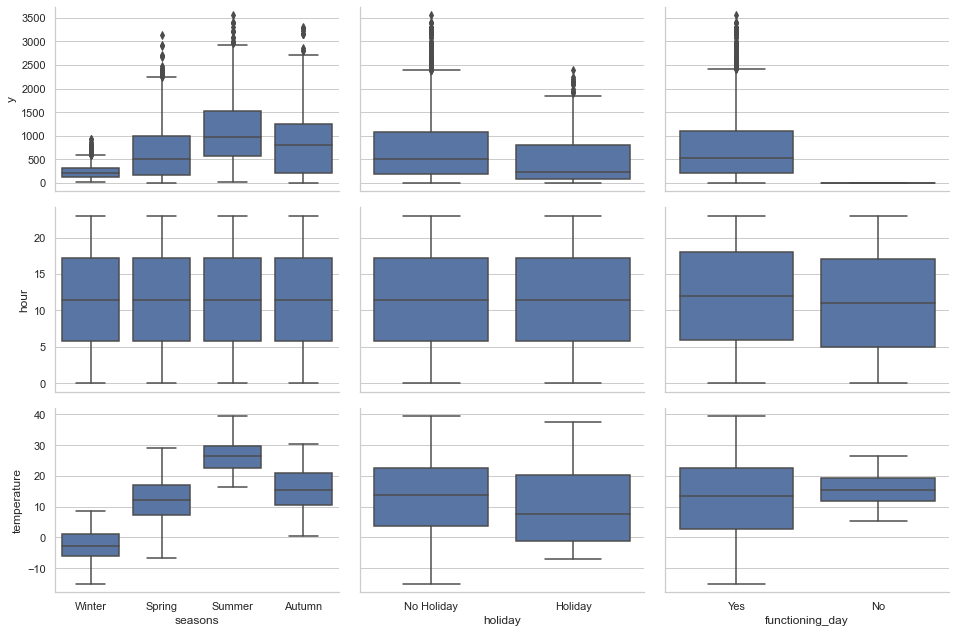

In [31]:
# plot matrix of numeric features against categorical features.
# can use a larger sample since there are fewer plots and they're simpler in nature.


def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sns.color_palette()[0]
    sns.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sns.PairGrid(data = bikes, y_vars = ['y', 'hour', 'temperature'], x_vars = categoric_vars,
                size = 3, aspect = 1.5)
g.map(boxgrid)
plt.show();

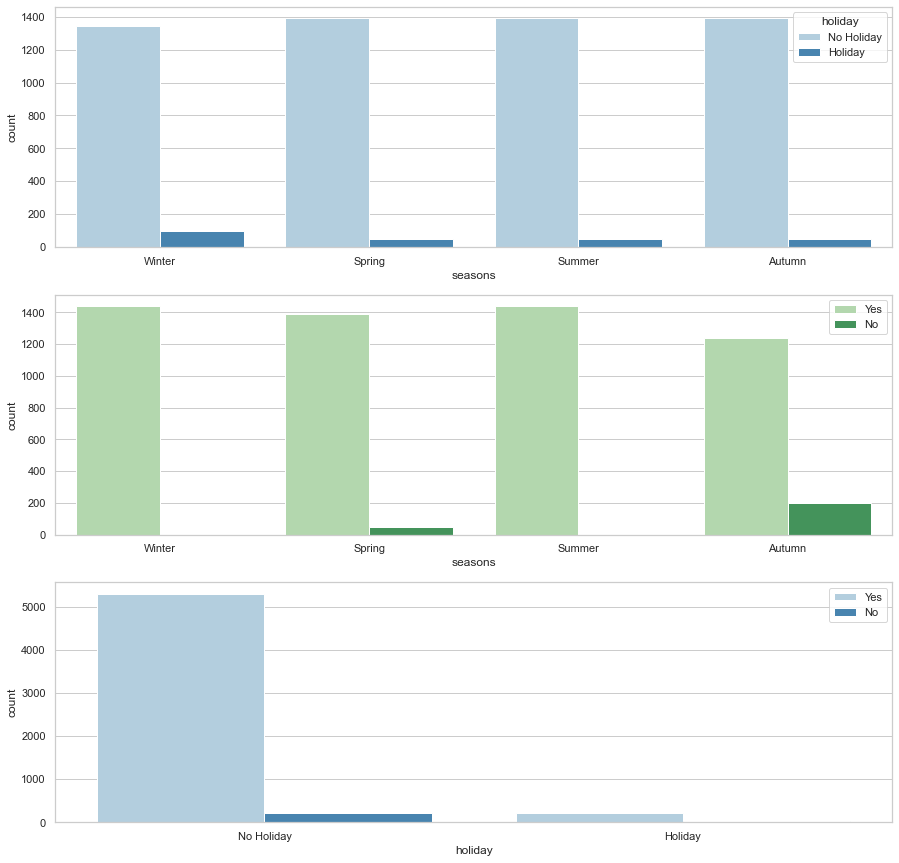

In [32]:
# plot categorical varaiables against each other:
plt.figure(figsize = [15, 15])

# subplot 1: color vs cut
plt.subplot(3, 1, 1)
sns.countplot(data = bikes, x = 'seasons', hue = 'holiday', palette = 'Blues')

# subplot 2: clarity vs. cut
ax = plt.subplot(3, 1, 3)
sns.countplot(data = bikes, x = 'holiday', hue = 'functioning_day', palette = 'Blues')
ax.legend() # re-arrange legend to reduce overlapping

# subplot 3: clarity vs. color, use different color palette
ax = plt.subplot(3, 1, 2)
sns.countplot(data = bikes, x = 'seasons', hue = 'functioning_day', palette = 'Greens')
ax.legend() # re-arrange legend to remove overlapping

plt.show()

from charts above we could see that tend to use bikes at Summer and do not use it heavily at Winter. Autumn is less than Summer and more closely to Spring. so we need to see the relationship between number of bikes with day of year.

Now I will explore the relation between each variable and y in log scale:

In [33]:
bikes.columns

Index(['ID', 'date', 'y', 'hour', 'temperature', 'humidity', 'wind_speed',
       'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'functioning_day', 'year_day',
       'weekday', 'month'],
      dtype='object')

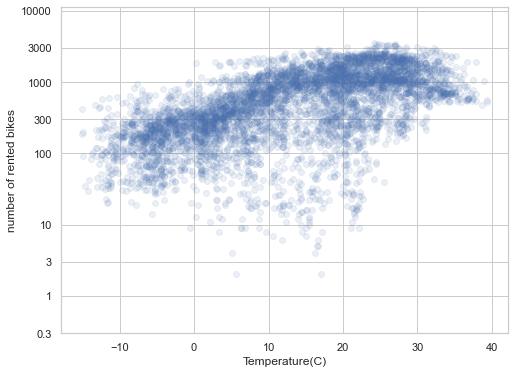

In [34]:
#draw the relation between Temperature and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'temperature', y = 'y', alpha = 1/10)
plt.xlabel('Temperature(C)')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

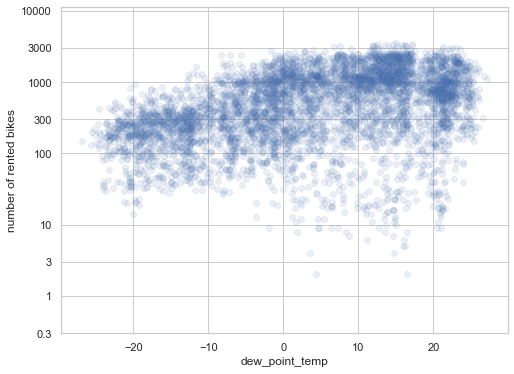

In [35]:
#draw the relation between dew_point_temp and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'dew_point_temp', y = 'y', alpha = 1/10)
plt.xlabel('dew_point_temp')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

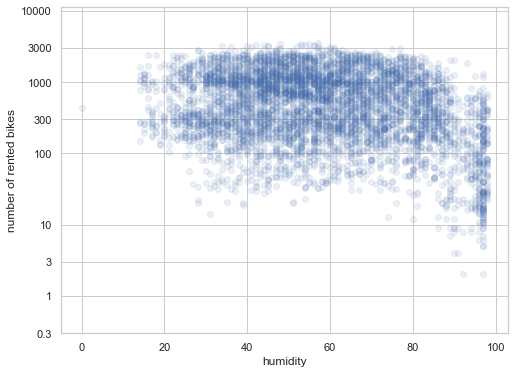

In [36]:
#draw the relation between humidity and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'humidity', y = 'y', alpha = 1/10)
plt.xlabel('humidity')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

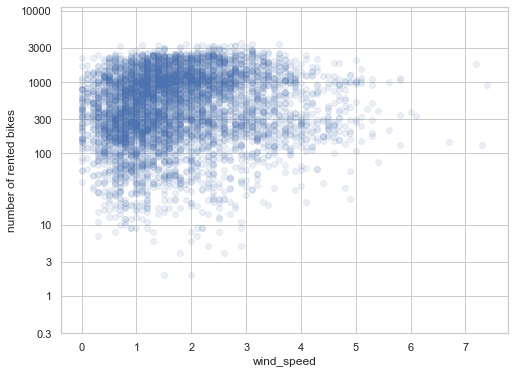

In [37]:
#draw the relation between wind_speed and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'wind_speed', y = 'y', alpha = 1/10)
plt.xlabel('wind_speed')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

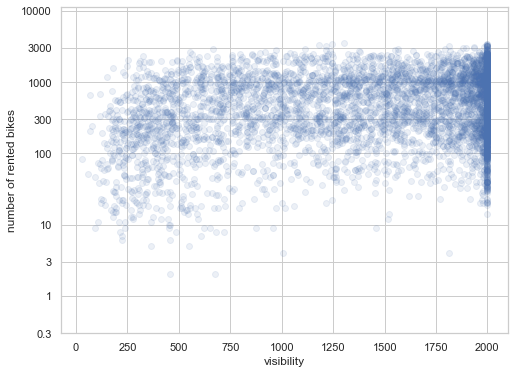

In [38]:

#draw the relation between visibility and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'visibility', y = 'y', alpha = 1/10)
plt.xlabel('visibility')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

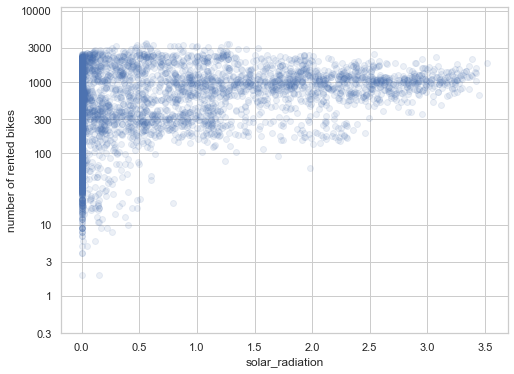

In [39]:

#draw the relation between solar_radiation and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'solar_radiation', y = 'y', alpha = 1/10)
plt.xlabel('solar_radiation')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

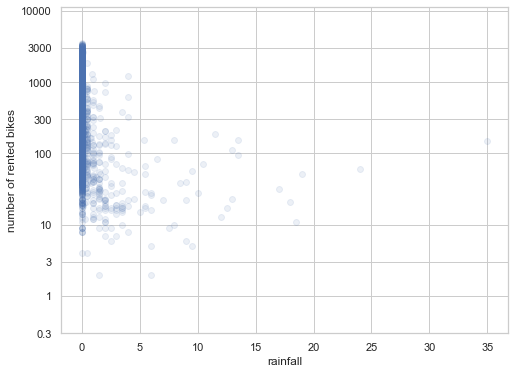

In [40]:
#draw the relation between rainfall and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'rainfall', y = 'y', alpha = 1/10)
plt.xlabel('rainfall')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

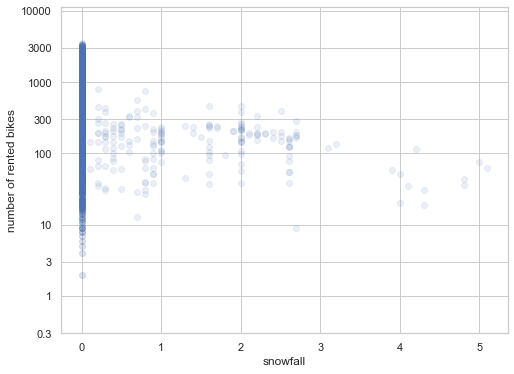

In [41]:
#draw the relation between snowfall and number of bikes in log scale:
plt.figure(figsize = [8, 6])
plt.scatter(data = bikes, x = 'snowfall', y = 'y', alpha = 1/10)
plt.xlabel('snowfall')
plt.yscale('log')
plt.yticks([0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000], [0.3, 1, 3, 10, 100, 300, 1000, 3000, 10000])
plt.ylabel('number of rented bikes')
plt.show()

<AxesSubplot:xlabel='hour', ylabel='y'>

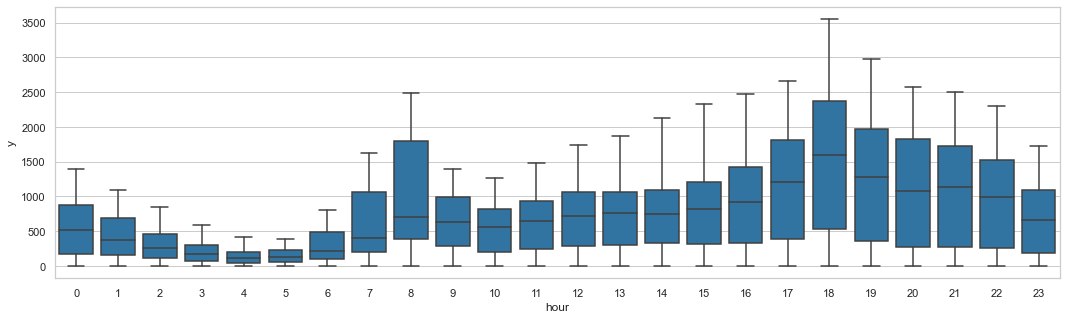

In [42]:
#see the distribution for every hour in the day
plt.figure(figsize=(18,5))
sns.boxplot(data= bikes , x= "hour", y="y", color = default_color)

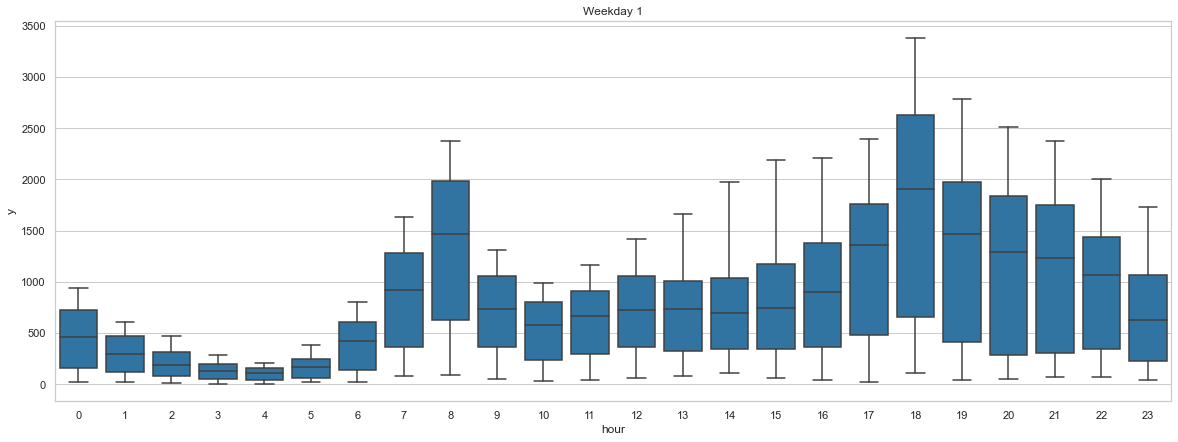

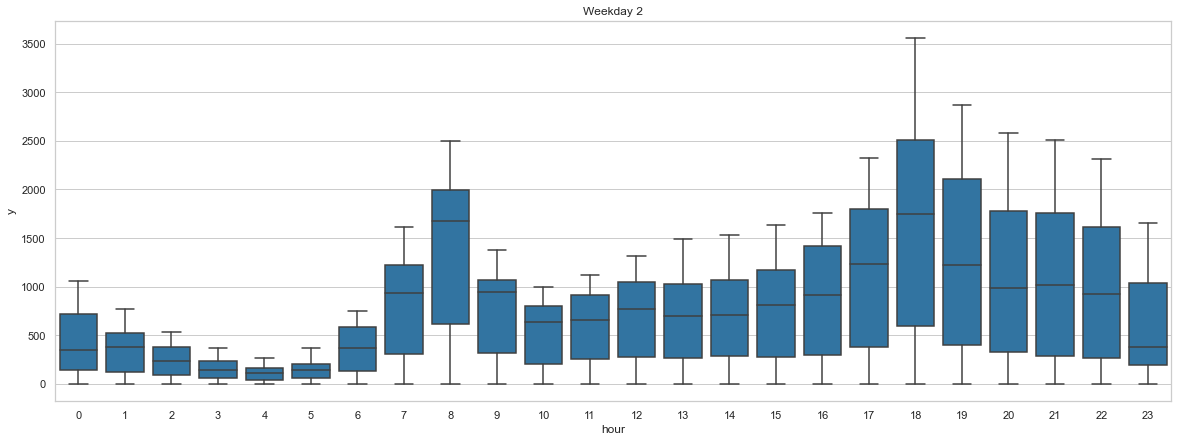

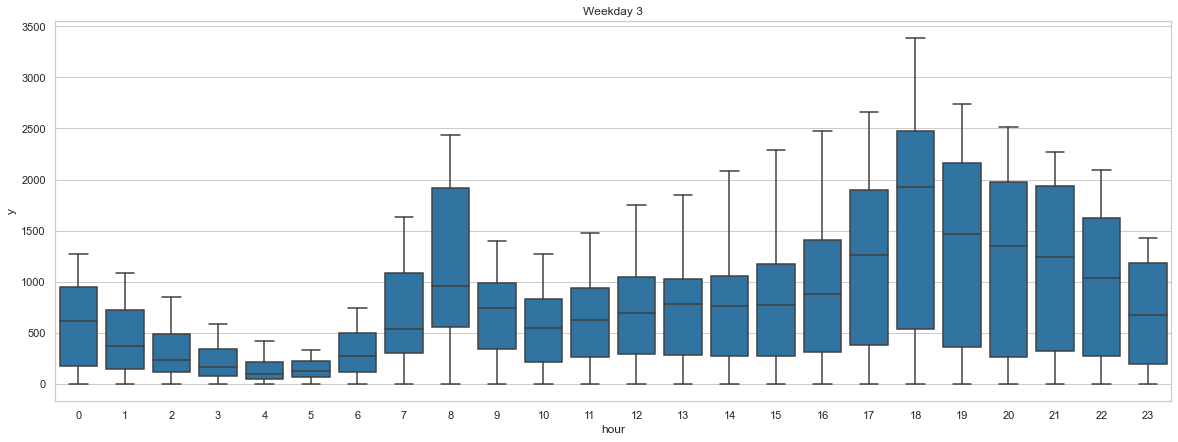

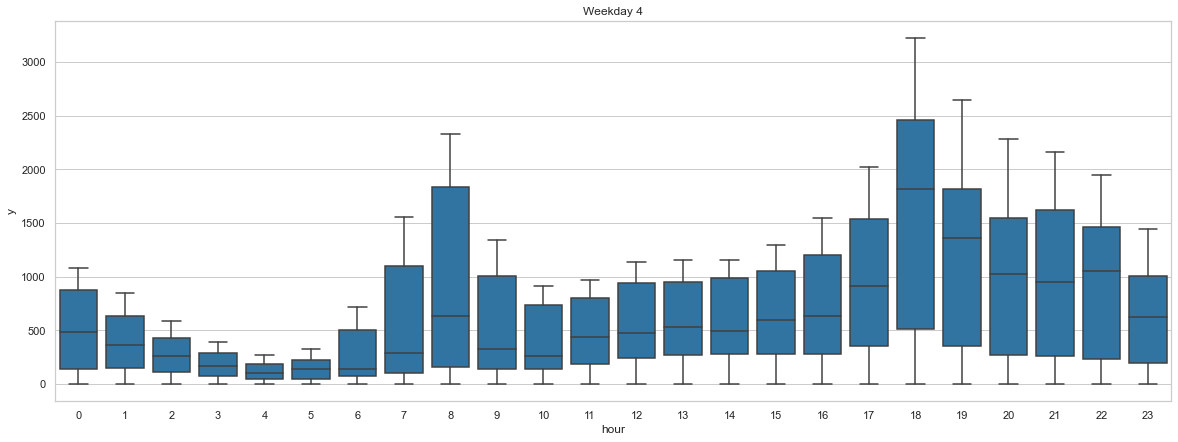

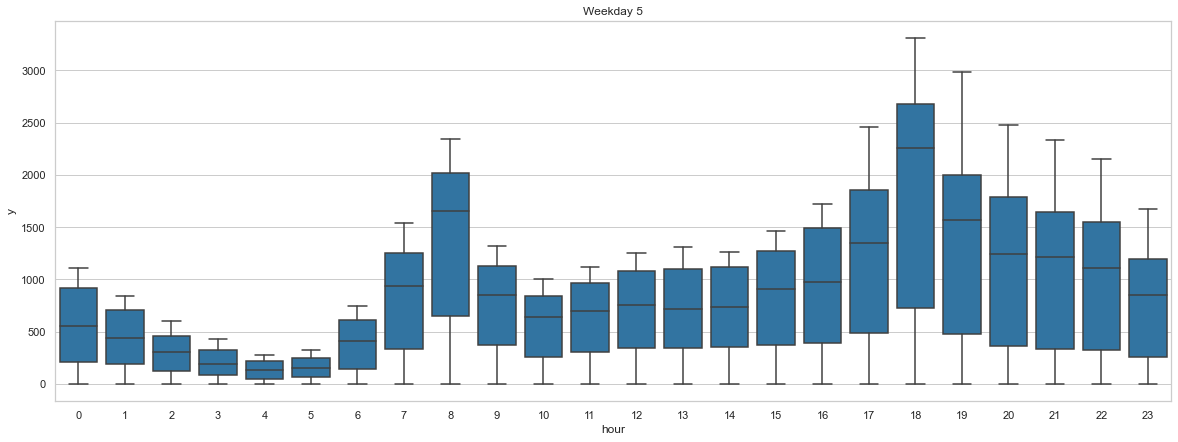

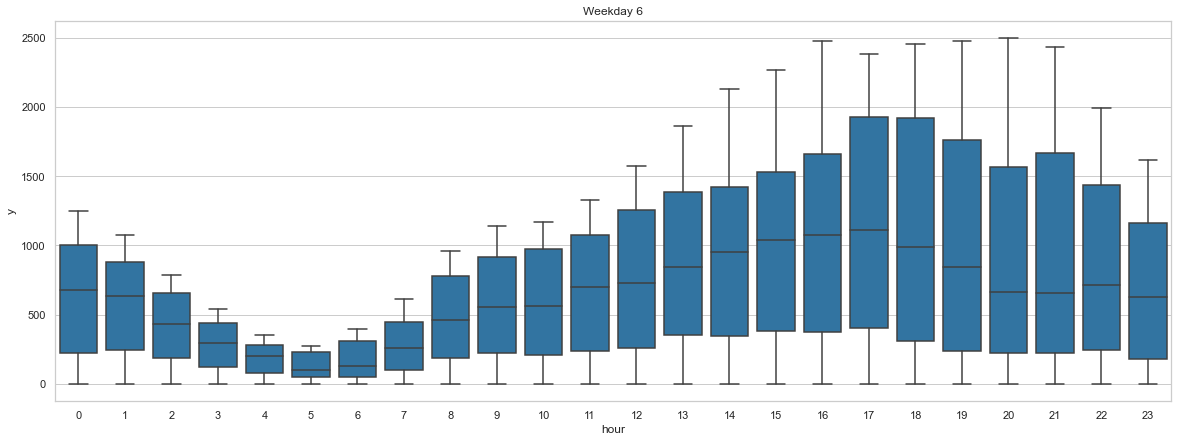

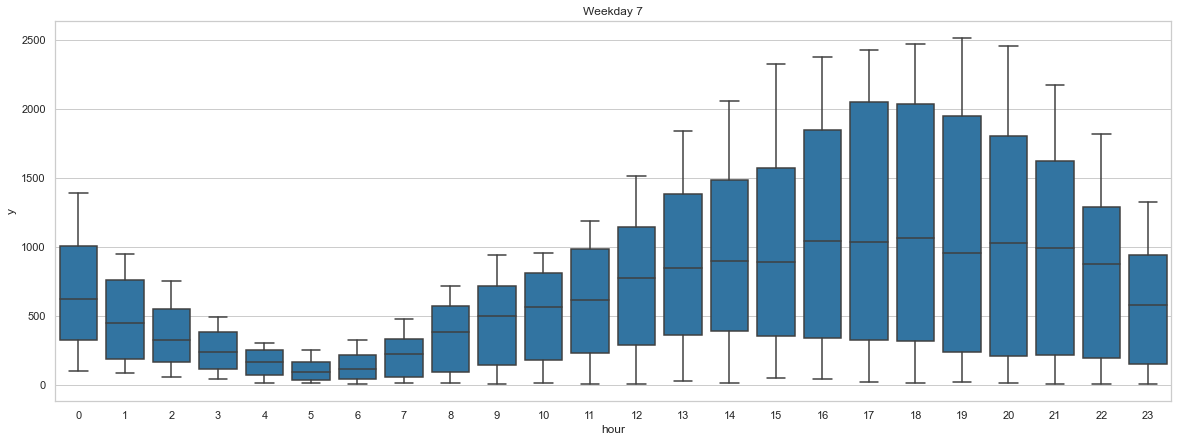

In [43]:
##see the distribution for every hour in the day for every weekday
for weekday in range(7):   
    weekday_df = bikes.query('weekday=={}'.format(weekday))
    plt.figure(figsize=(20,7))
    sns.boxplot(data= weekday_df , x= "hour", y="y", color = default_color)
    plt.title("Weekday {}".format(weekday + 1))


I could see a pattern for workdays (Mondays to Fridays). there are a peak at 8:00 am when people going to work and at 18:00 pm when people return from work. there is also interesting thing that more people use bikes at returning from work hours than going to work hours. that may happens because people at morning may use the bikes only for going to work but at 18:00 there are people who rent a bike for another reason for going back home from work. 

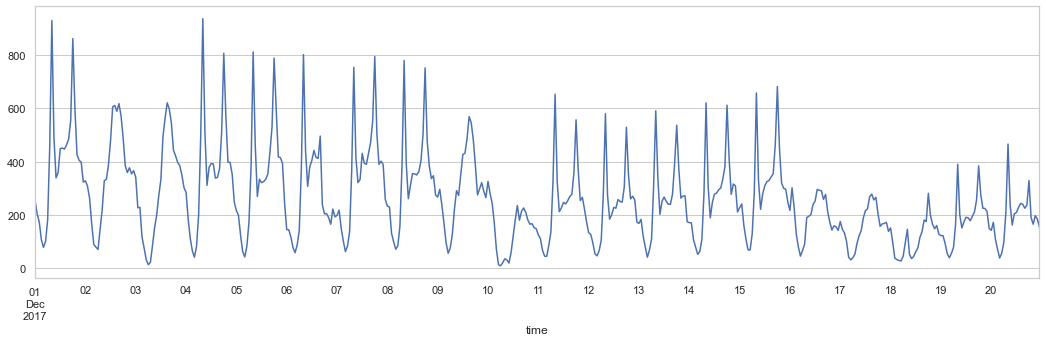

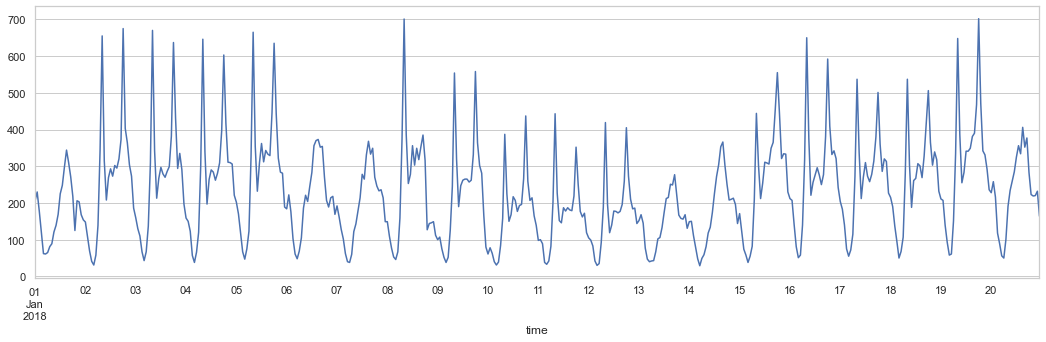

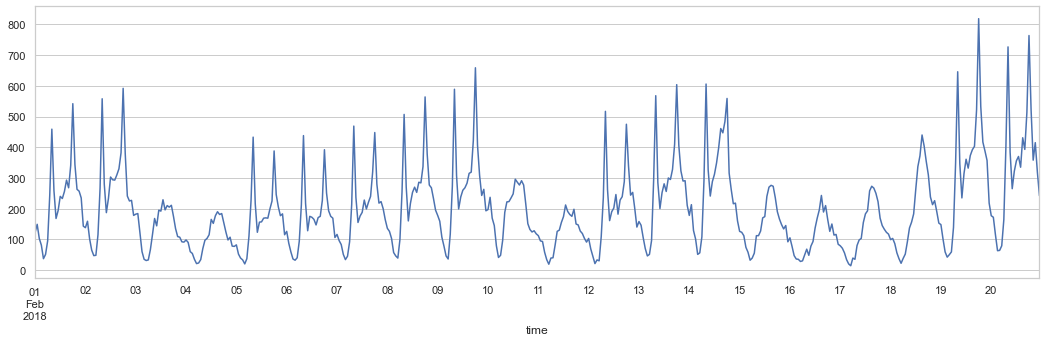

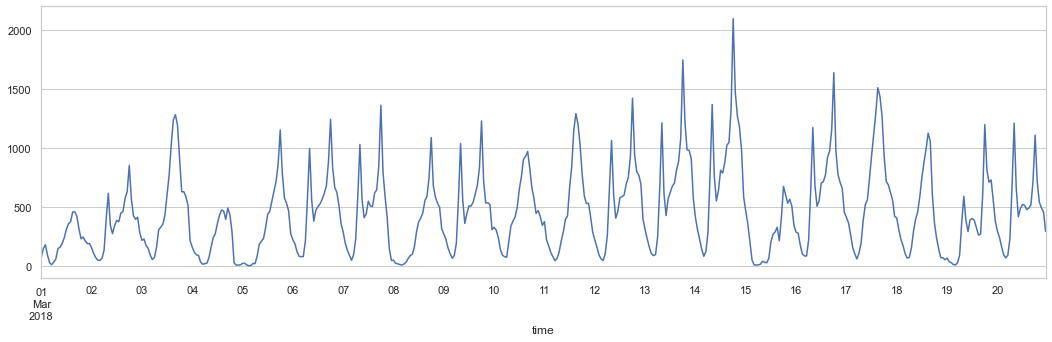

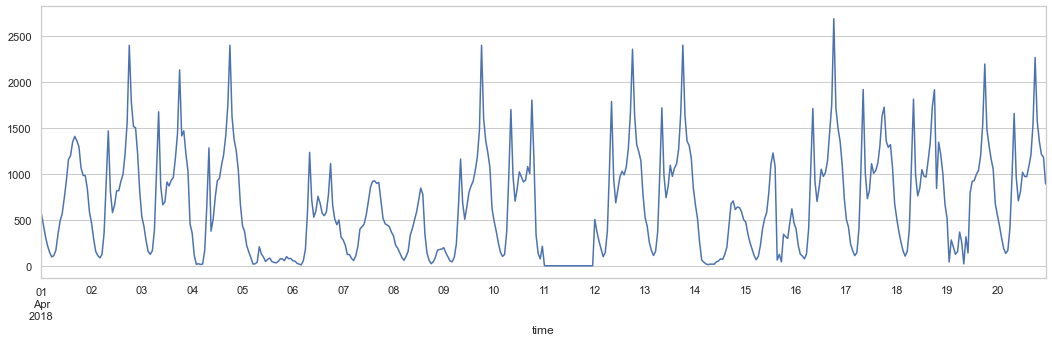

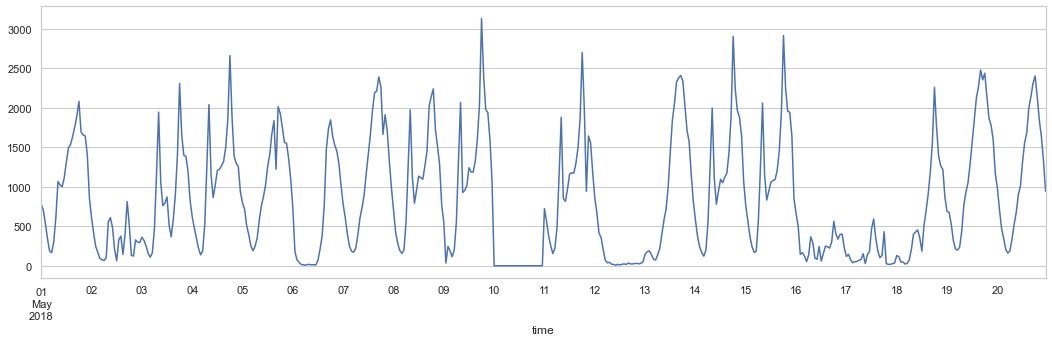

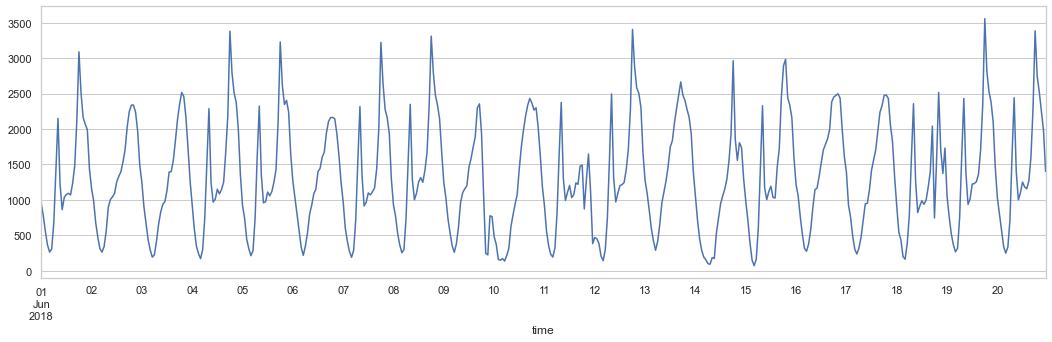

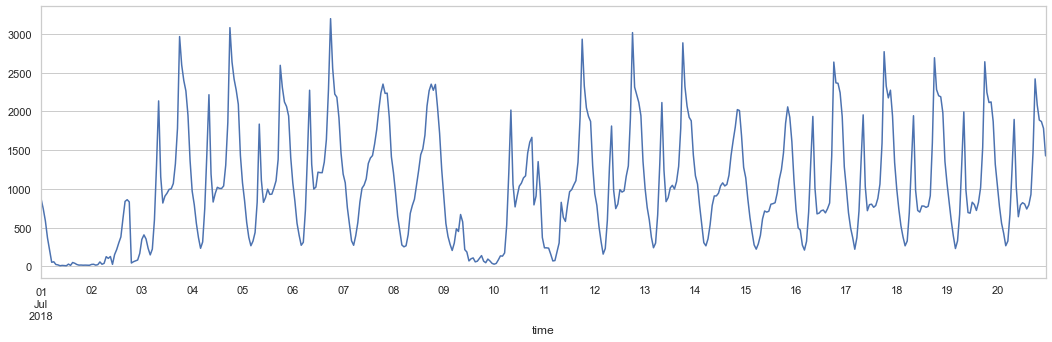

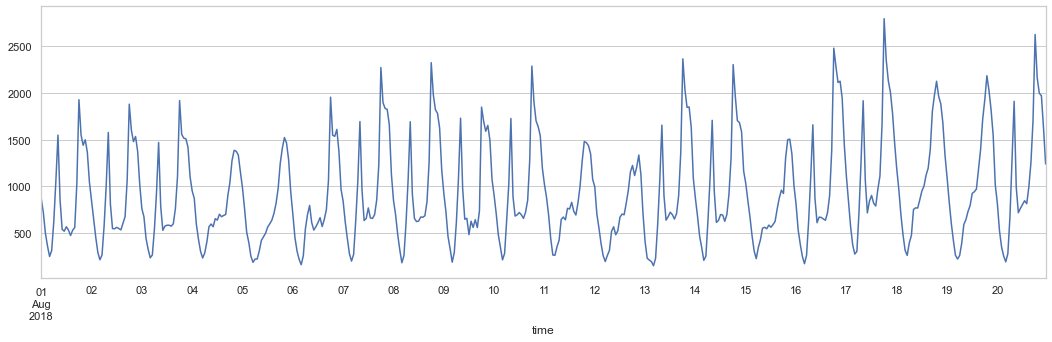

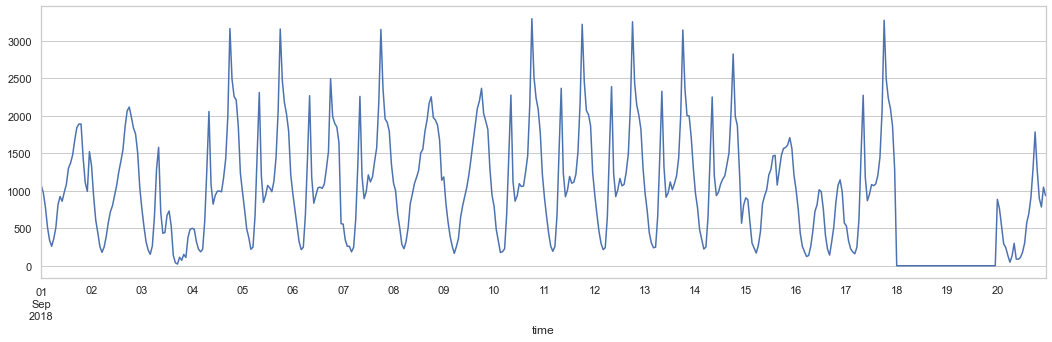

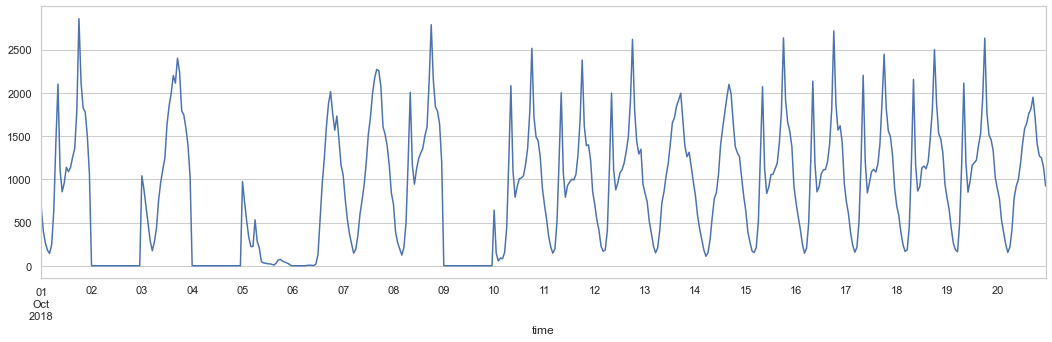

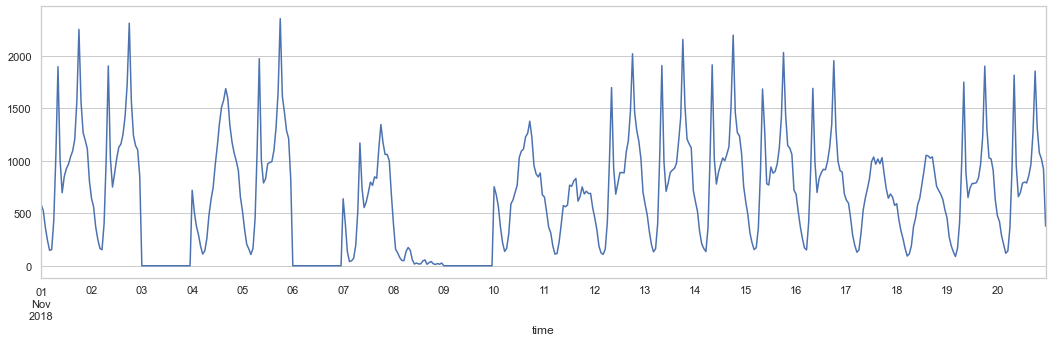

In [44]:
#timeseries per hour for each month:
ax = plt.figure(figsize=(18,5))
bikes['y'].loc[bikes.index.month==(12)].plot()
for month in range(11):
    plt.figure(figsize=(18,5))
    bikes['y'].loc[bikes.index.month==(month+1)].plot()
    

# Feature Engineering:

### #1- make a new column for workday(binary):

In [45]:
bikes['work_day'] = np.where((bikes['weekday'] == 5) | (bikes['weekday'] == 6) , False, True)
bikes.loc[bikes.holiday == 'Holiday', 'work_day'] = False
bikes[bikes['holiday']=='Holiday'].head(2)

ID       date    y  hour  temperature  humidity  \
time                                                                    
2018-01-01 00:00:00  480 2018-01-01  206     0         -3.2        40   
2018-01-01 01:00:00  481 2018-01-01  230     1         -3.3        41   

                     wind_speed  visibility  dew_point_temp  solar_radiation  \
time                                                                           
2018-01-01 00:00:00         0.5        1358           -14.9              0.0   
2018-01-01 01:00:00         0.7        2000           -14.7              0.0   

                     rainfall  snowfall seasons  holiday functioning_day  \
time                                                                       
2018-01-01 00:00:00       0.0       0.0  Winter  Holiday             Yes   
2018-01-01 01:00:00       0.0       0.0  Winter  Holiday             Yes   

                     year_day  weekday  month  work_day  
time                                                     
2018-01-01 00:00:00         1        0      1     False  
2018-01-01 01:00:00         1        0      1     False

### #2- make a new column for heat index:

In [46]:
#Heat index 
bikes['temp_F'] = 1.8*bikes['temperature'] + 32
T = bikes['temp_F']
RH = bikes['humidity']
bikes['heat_index'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
bikes[bikes['holiday']=='Holiday'].head(2)

ID       date    y  hour  temperature  humidity  \
time                                                                    
2018-01-01 00:00:00  480 2018-01-01  206     0         -3.2        40   
2018-01-01 01:00:00  481 2018-01-01  230     1         -3.3        41   

                     wind_speed  visibility  dew_point_temp  solar_radiation  \
time                                                                           
2018-01-01 00:00:00         0.5        1358           -14.9              0.0   
2018-01-01 01:00:00         0.7        2000           -14.7              0.0   

                     ...  snowfall  seasons  holiday functioning_day year_day  \
time                 ...                                                        
2018-01-01 00:00:00  ...       0.0   Winter  Holiday             Yes        1   
2018-01-01 01:00:00  ...       0.0   Winter  Holiday             Yes        1   

                     weekday  month  work_day  temp_F  heat_index  
time                                                               
2018-01-01 00:00:00        0      1     False   26.24  156.255396  
2018-01-01 01:00:00        0      1     False   26.06  159.262048  

[2 rows x 21 columns]

### #3- Moving averges:

In [47]:
a=3   #best 3
b=5   #best 5
c=6
bikes['rainfall_MA'] = bikes['rainfall'].rolling(window=a, min_periods=1).mean()
bikes['snowfall_MA'] = bikes['snowfall'].rolling(window=b, min_periods=1).mean()
bikes['temperature_MA'] = bikes['temperature'].rolling(window=c, min_periods=1).mean()
bikes.head(2)

ID       date    y  hour  temperature  humidity  \
time                                                                   
2017-12-01 00:00:00   0 2017-12-01  254     0         -5.2        37   
2017-12-01 01:00:00   1 2017-12-01  204     1         -5.5        38   

                     wind_speed  visibility  dew_point_temp  solar_radiation  \
time                                                                           
2017-12-01 00:00:00         2.2        2000           -17.6              0.0   
2017-12-01 01:00:00         0.8        2000           -17.6              0.0   

                     ...  functioning_day  year_day weekday month work_day  \
time                 ...                                                     
2017-12-01 00:00:00  ...              Yes       335       4    12     True   
2017-12-01 01:00:00  ...              Yes       335       4    12     True   

                     temp_F  heat_index  rainfall_MA  snowfall_MA  \
time                                                                
2017-12-01 00:00:00   22.64  160.830468          0.0          0.0   
2017-12-01 01:00:00   22.10  165.722529          0.0          0.0   

                     temperature_MA  
time                                 
2017-12-01 00:00:00           -5.20  
2017-12-01 01:00:00           -5.35  

[2 rows x 24 columns]

### #4- cycles for timeseries components:

In [48]:
timestamp_s = bikes.index.map(pd.Timestamp.timestamp)


day = 24*60*60
week = 7 * day
year = (365.2425)*day

bikes['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
bikes['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
bikes['week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
bikes['week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
bikes['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
bikes['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

bikes.head(2)

ID       date    y  hour  temperature  humidity  \
time                                                                   
2017-12-01 00:00:00   0 2017-12-01  254     0         -5.2        37   
2017-12-01 01:00:00   1 2017-12-01  204     1         -5.5        38   

                     wind_speed  visibility  dew_point_temp  solar_radiation  \
time                                                                           
2017-12-01 00:00:00         2.2        2000           -17.6              0.0   
2017-12-01 01:00:00         0.8        2000           -17.6              0.0   

                     ...  heat_index  rainfall_MA snowfall_MA temperature_MA  \
time                 ...                                                       
2017-12-01 00:00:00  ...  160.830468          0.0         0.0          -5.20   
2017-12-01 01:00:00  ...  165.722529          0.0         0.0          -5.35   

                          Day sin   Day cos  week sin  week cos  Year sin  \
time                                                                        
2017-12-01 00:00:00 -4.677307e-12  1.000000  0.781831   0.62349 -0.503023   
2017-12-01 01:00:00  2.588190e-01  0.965926  0.804598   0.59382 -0.502403   

                     Year cos  
time                           
2017-12-01 00:00:00  0.864273  
2017-12-01 01:00:00  0.864633  

[2 rows x 30 columns]

# Data cleaning for modeling:

## #1-encoding for categorical variables:

In [49]:
bikes["functioning_day"] = bikes["functioning_day"].replace({'Yes': 1, 'No': 0})
bikes["holiday"] = bikes["holiday"].replace({'No Holiday': 1 , 'Holiday': 0})
bikes["seasons"] = bikes["seasons"].replace({'Winter': 1, 'Spring': 2,"Summer": 3, "Autumn": 4})

bikes[categoric_vars].head(2)

seasons  holiday  functioning_day
time                                                  
2017-12-01 00:00:00        1        1                1
2017-12-01 01:00:00        1        1                1

## 2-Removing outliers:

In [50]:
#outliers for y : 
print(bikes.shape)
bikes = bikes.drop(bikes[bikes['y']<=2].index)
#bikes = bikes.drop(bikes[bikes['y']> 2500].index)
print(bikes.shape)

(5760, 30)
(5511, 30)


In [51]:
#final 
bikes.head(1).T

time                      2017-12-01
ID                                 0
date             2017-12-01 00:00:00
y                                254
hour                               0
temperature                     -5.2
humidity                          37
wind_speed                       2.2
visibility                      2000
dew_point_temp                 -17.6
solar_radiation                    0
rainfall                           0
snowfall                           0
seasons                            1
holiday                            1
functioning_day                    1
year_day                         335
weekday                            4
month                             12
work_day                        True
temp_F                         22.64
heat_index                    160.83
rainfall_MA                        0
snowfall_MA                        0
temperature_MA                  -5.2
Day sin                 -4.67731e-12
Day cos                            1
week sin                    0.781831
week cos                     0.62349
Year sin                   -0.503023
Year cos                    0.864273

## Matching test data features with our training data features:


In [54]:
df_test = pd.read_csv('test.csv', parse_dates=[1], dayfirst=True)
df_test.head()

ID       Date  Hour  Temperature(�C)  Humidity(%)  Wind speed (m/s)  \
0  5760 2017-12-21     0             -1.3           90               2.0   
1  5761 2017-12-21     1             -1.8           90               1.6   
2  5762 2017-12-21     2             -2.2           88               1.4   
3  5763 2017-12-21     3             -2.9           89               1.3   
4  5764 2017-12-21     4             -3.6           91               1.2   

   Visibility (10m)  Dew point temperature(�C)  Solar Radiation (MJ/m2)  \
0               259                       -2.7                      0.0   
1               263                       -3.2                      0.0   
2               348                       -3.9                      0.0   
3               288                       -4.4                      0.0   
4               241                       -4.8                      0.0   

   Rainfall(mm)  Snowfall (cm) Seasons     Holiday Functioning Day  
0           0.0            2.2  Winter  No Holiday             Yes  
1           0.0            2.2  Winter  No Holiday             Yes  
2           0.0            2.2  Winter  No Holiday             Yes  
3           0.0            2.2  Winter  No Holiday             Yes  
4           0.0            2.2  Winter  No Holiday             Yes

In [55]:
df_test['year'] = pd.to_datetime(df_test.Date).dt.year
df_test['month'] = pd.to_datetime(df_test.Date).dt.month
df_test['day'] = pd.to_datetime(df_test.Date).dt.day
df_test['time'] = pd.to_datetime(df_test[['year', 'month', 'day', 'Hour']])
df_test = df_test.set_index('time')
df_test.drop(['year', 'month', 'day'], axis=1, inplace=True)

df_test.head(2)

ID       Date  Hour  Temperature(�C)  Humidity(%)  \
time                                                                       
2017-12-21 00:00:00  5760 2017-12-21     0             -1.3           90   
2017-12-21 01:00:00  5761 2017-12-21     1             -1.8           90   

                     Wind speed (m/s)  Visibility (10m)  \
time                                                      
2017-12-21 00:00:00               2.0               259   
2017-12-21 01:00:00               1.6               263   

                     Dew point temperature(�C)  Solar Radiation (MJ/m2)  \
time                                                                      
2017-12-21 00:00:00                       -2.7                      0.0   
2017-12-21 01:00:00                       -3.2                      0.0   

                     Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
time                                                                   
2017-12-21 00:00:00           0.0            2.2  Winter  No Holiday   
2017-12-21 01:00:00           0.0            2.2  Winter  No Holiday   

                    Functioning Day  
time                                 
2017-12-21 00:00:00             Yes  
2017-12-21 01:00:00             Yes

In [56]:
#renaming coulumns:
features = ['ID','date' , 'hour', 'temperature', 'humidity',
            'wind_speed', 'visibility', 'dew_point_temp',
            'solar_radiation', 'rainfall', 'snowfall', 'seasons', 'holiday', 'functioning_day']
df_test.columns = features
df_test.head(1)

ID       date  hour  temperature  humidity  wind_speed  \
time                                                                   
2017-12-21  5760 2017-12-21     0         -1.3        90         2.0   

            visibility  dew_point_temp  solar_radiation  rainfall  snowfall  \
time                                                                          
2017-12-21         259            -2.7              0.0       0.0       2.2   

           seasons     holiday functioning_day  
time                                            
2017-12-21  Winter  No Holiday             Yes

In [57]:
# order seasons column:
ordered = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ["Winter", "Spring", "Summer", "Autumn" ])
df_test['seasons'] = df_test['seasons'].astype(ordered)

In [58]:
#Extract day of year:
df_test['year_day'] = pd.to_datetime(df_test.date).dt.dayofyear
df_test['weekday'] = pd.to_datetime(df_test.date).dt.weekday
df_test['month'] = pd.to_datetime(df_test.date).dt.month

In [59]:
df_test.head(1)

ID       date  hour  temperature  humidity  wind_speed  \
time                                                                   
2017-12-21  5760 2017-12-21     0         -1.3        90         2.0   

            visibility  dew_point_temp  solar_radiation  rainfall  snowfall  \
time                                                                          
2017-12-21         259            -2.7              0.0       0.0       2.2   

           seasons     holiday functioning_day  year_day  weekday  month  
time                                                                      
2017-12-21  Winter  No Holiday             Yes       355        3     12

In [60]:
### #1- make a new column for workday(binary):
df_test['work_day'] = np.where((df_test['weekday'] == 5) | (df_test['weekday'] == 6) , False, True)
df_test.loc[df_test.holiday == 'Holiday', 'work_day'] = False
df_test[df_test['holiday']=='Holiday'].head(2)

## #2-Heat index 
df_test['temp_F'] = 1.8*df_test['temperature'] + 32
T = df_test['temp_F']
RH = df_test['humidity']
df_test['heat_index'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
df_test[df_test['holiday']=='Holiday'].head(2)

## #3-moving avgs
a=3   #best 3
b=5   #best 5
c=6
df_test['rainfall_MA'] = df_test['rainfall'].rolling(window=a, min_periods=1).mean()
df_test['snowfall_MA'] = df_test['snowfall'].rolling(window=b, min_periods=1).mean()
df_test['temperature_MA'] = df_test['temperature'].rolling(window=c, min_periods=1).mean()
df_test.head(2)

timestamp_s = df_test.index.map(pd.Timestamp.timestamp)

## #3-cycles for timeseries
day = 24*60*60
week = 7 * day
year = (365.2425)*day

df_test['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_test['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df_test['week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df_test['week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df_test['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df_test['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df_test.head(2)

ID       date  hour  temperature  humidity  wind_speed  \
time                                                                            
2017-12-21 00:00:00  5760 2017-12-21     0         -1.3        90         2.0   
2017-12-21 01:00:00  5761 2017-12-21     1         -1.8        90         1.6   

                     visibility  dew_point_temp  solar_radiation  rainfall  \
time                                                                         
2017-12-21 00:00:00         259            -2.7              0.0       0.0   
2017-12-21 01:00:00         263            -3.2              0.0       0.0   

                     ...  heat_index rainfall_MA snowfall_MA temperature_MA  \
time                 ...                                                      
2017-12-21 00:00:00  ...  169.289307         0.0         2.2          -1.30   
2017-12-21 01:00:00  ...  174.825926         0.0         2.2          -1.55   

                          Day sin   Day cos      week sin  week cos  Year sin  \
time                                                                            
2017-12-21 00:00:00 -6.018026e-12  1.000000 -8.015114e-14  1.000000 -0.182017   
2017-12-21 01:00:00  2.588190e-01  0.965926  3.739119e-02  0.999301 -0.181312   

                     Year cos  
time                           
2017-12-21 00:00:00  0.983295  
2017-12-21 01:00:00  0.983426  

[2 rows x 29 columns]

In [61]:
#encoding for categorical varibales
df_test["functioning_day"] = df_test["functioning_day"].replace({'Yes': 1, 'No': 0})
df_test["holiday"] = df_test["holiday"].replace({'No Holiday': 1 , 'Holiday': 0})
df_test["seasons"] = df_test["seasons"].replace({'Winter': 1, 'Spring': 2,"Summer": 3, "Autumn": 4})

df_test[categoric_vars].head(2)

seasons  holiday  functioning_day
time                                                  
2017-12-21 00:00:00        1        1                1
2017-12-21 01:00:00        1        1                1

In [62]:
df_test.head(1).T

time                      2017-12-21
ID                              5760
date             2017-12-21 00:00:00
hour                               0
temperature                     -1.3
humidity                          90
wind_speed                         2
visibility                       259
dew_point_temp                  -2.7
solar_radiation                    0
rainfall                           0
snowfall                         2.2
seasons                            1
holiday                            1
functioning_day                    1
year_day                         355
weekday                            3
month                             12
work_day                        True
temp_F                         29.66
heat_index                   169.289
rainfall_MA                        0
snowfall_MA                      2.2
temperature_MA                  -1.3
Day sin                 -6.01803e-12
Day cos                            1
week sin                -8.01511e-14
week cos                           1
Year sin                   -0.182017
Year cos                    0.983295

In [63]:
bikes.columns

Index(['ID', 'date', 'y', 'hour', 'temperature', 'humidity', 'wind_speed',
       'visibility', 'dew_point_temp', 'solar_radiation', 'rainfall',
       'snowfall', 'seasons', 'holiday', 'functioning_day', 'year_day',
       'weekday', 'month', 'work_day', 'temp_F', 'heat_index', 'rainfall_MA',
       'snowfall_MA', 'temperature_MA', 'Day sin', 'Day cos', 'week sin',
       'week cos', 'Year sin', 'Year cos'],
      dtype='object')

# Modelling

## Random forrest:

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

feats = [       
                'hour',
                'temperature',
                'humidity',
                'wind_speed',
                'visibility',
                #'dew_point_temp',
                'solar_radiation',
                'rainfall',
                'snowfall',
                #'seasons',
                #'holiday',
                #'functioning_day',
    
                'year_day',
                #'weekday',
                #'month',
                'work_day',
               
                #'temp_F',
                #'heat_index',

    
                'rainfall_MA',
                'snowfall_MA',
                #'temperature_MA',
    
                #'Day sin',
                #'Day cos',
                'week sin',
                'week cos',
                'Year sin',
                'Year cos',
                #'season sin',
                #'season cos',
    
                #'is_rush'
                #'is_june'
                
                
]

#splitting data
xtrain_xgb = bikes[feats]
ytrain_xgb = bikes['y']
ytrain_xgb_log = np.log(bikes['y']).replace(np.NINF, 0)

xtest_xgb = df_test[feats]

regr = RandomForestRegressor(max_depth=100, random_state=0)
regr.fit(xtrain_xgb, ytrain_xgb_log)

#predicitng
ypred_log = regr.predict(xtest_xgb)
ypred = np.exp(ypred_log)

#put all non-functioning hours to Zero
ypred[df_test['functioning_day']==0] = 0

ypred = np.floor(ypred)
ypred

array([151., 155., 108., ..., 556., 552., 474.])

## XgBoost:

In [65]:
feats = [       
                'hour',
                'temperature',
                'humidity',
                'wind_speed',
                'visibility',
                #'dew_point_temp',
                'solar_radiation',
                'rainfall',
                'snowfall',
                #'seasons',
                #'holiday',
                #'functioning_day',
    
                'year_day',
                #'weekday',
                #'month',
                'work_day',
               
                #'temp_F',
                #'heat_index',

    
                'rainfall_MA',
                'snowfall_MA',
                #'temperature_MA',
    
                #'Day sin',
                #'Day cos',
                'week sin',
                'week cos',
                'Year sin',
                'Year cos',
                #'season sin',
                #'season cos',
    
                #'is_rush'
                #'is_june'
                
                
]

#splitting data
xtrain_xgb = bikes[feats]
ytrain_xgb = bikes['y']
ytrain_xgb_log = np.log(bikes['y']).replace(np.NINF, 0)

xtest_xgb = df_test[feats]

#training
xgbr = xgb.XGBRegressor(validate_parameters=True, max_depth=100, n_estimators=50, gamma=0.865,min_child_weight=90,
                            max_delta_step=3, learning_rate=0.2, random_state=42,verbosity=0,
                            alpha=0.025 ,tree_method = 'auto', objective='reg:squarederror')
xgbr.fit(xtrain_xgb, ytrain_xgb_log)

#predicitng
ypred_log = xgbr.predict(xtest_xgb)
ypred = np.exp(ypred_log)

#put all non-functioning hours to Zero
ypred[df_test['functioning_day']==0] = 0


ypred = np.floor(ypred)
ypred

array([164., 121., 111., ..., 659., 619., 477.], dtype=float32)

In [66]:
df_submission = df_test[['ID']]
df_submission['y'] = ypred
df_submission

ID      y
time                            
2017-12-21 00:00:00  5760  164.0
2017-12-21 01:00:00  5761  121.0
2017-12-21 02:00:00  5762  111.0
2017-12-21 03:00:00  5763   65.0
2017-12-21 04:00:00  5764   49.0
...                   ...    ...
2018-11-30 19:00:00  8755  830.0
2018-11-30 20:00:00  8756  686.0
2018-11-30 21:00:00  8757  659.0
2018-11-30 22:00:00  8758  619.0
2018-11-30 23:00:00  8759  477.0

[3000 rows x 2 columns]

In [67]:
df_submission.to_csv('submission.csv', index=False)